In [2]:
import numpy as np, pandas as pd
from matplotlib import pyplot as plt

class NeuralNetwork:
    
    def __init__(self, no_of_layers = 3, no_of_nodes = [1, 2, 1]):
        self.no_of_layers = no_of_layers
        self.no_of_nodes = no_of_nodes
        self.reg_lambda = 0.1
        self.learning_rate = 1.0
        self.epochs = 200
        self.initiate_network()
        self.print = False

    # Initializing all the weights 
    # np.random.randn() - normal distribution with mean = 0 and variance = 1
    def initiate_network(self):
        parameters = []
        for layer in range(self.no_of_layers-1):
            weight_matrix = np.random.randn(self.no_of_nodes[layer+1], self.no_of_nodes[layer]+1)
            parameters.append(weight_matrix)
        self.parameters = parameters

    
    def sigmoid(self, x):
        return 1/(1 + np.exp(-x))
    
    
    # For loop to iterate over hidden layers.
    # np.matmul() - to compute all the forward operations.
    def feed_forward(self, x):
        activations = []
        a = np.append(1, x)
        for layer in range(self.no_of_layers-1):
            activations.append(a)
            z = np.matmul(self.parameters[layer], a)
            activation = self.sigmoid(z)
            a = np.append(1, activation)
        activations.append(activation)
        if self.print:
            print("--------------------Activations--------------------")
            for a in activations:
                print(a)
            print()
        return activation
    
    
    # np.delete() - to remove bias weights in cost calculation
    def compute_cost(self, data):
        cost = 0
        n = len(data)
        for x, y in data:
            f = self.feed_forward(x)
            j = -(y * np.log(f + np.finfo(float).eps) + (1-np.array(y)) * np.log(1-f+np.finfo(float).eps))
            cost += (np.sum(np.nan_to_num(j)) / n)
        reg_cost = 0.5*(1/n)*sum(np.sum(np.square(np.delete(w_layer, [0]*len(w_layer), axis=1))) for w_layer in self.parameters)
        total_cost = (cost + self.reg_lambda * reg_cost)
        if self.print:
            print("Average Instance cost J(I)      = ", cost)
            print("Total Regularized Cost(J)       = ", total_cost, "\n")
        return total_cost
    

    # **** This is implemented using arrays, vector and matrix operations.
    # **** For loops only used when iterating over hidden layers.
    def back_prop(self, x, y):
        z_layers = []
        activations = [x]
        a = np.append(1, x)

        for layer in range(len(self.parameters)):
            z = np.matmul(self.parameters[layer], a)
            z_layers.append(z)
            activations.append(self.sigmoid(z))
            a = np.append(1, self.sigmoid(z))
        
        deltas = {}
        delta = activations[-1] - y
        deltas[len(self.parameters)] = delta
        for layer in reversed(range(1, self.no_of_layers-1)):
            deltas[layer] = np.matmul(deltas[layer+1], np.delete(self.parameters[layer], [0]*len(self.parameters[layer]), axis = 1)) * activations[layer] * (1 - activations[layer])
        
        if self.print:
            print("-------------------Deltas of hidden and output layers--------------------")
            print(deltas, "\n")
            print("-------Gradients (not regularized) of network given a single input-------")
        gradients = []
        for layer in range(self.no_of_layers-1):
            gradient = np.array([np.append(1,activations[layer]),]*self.no_of_nodes[layer+1]) * np.array([deltas[layer+1],]*(1+self.no_of_nodes[layer])).transpose()
            gradients.append(gradient)
            if self.print:
                print(gradient,"\n")
        return gradients
    

    def gradientDescent(self, dataset):
        self.initiate_network()
        #print("Initial cost (J)           = ", self.compute_cost(dataset))
        #print()
        for epoch in range(self.epochs):
            self.update(dataset)
            #if epoch % 100 == 0:
            #    print("Epoch", epoch, ": Cost (J) = ", self.compute_cost(dataset))
        #print()
        #print("Final cost (J)             = ", self.compute_cost(dataset))
        #print("----------------------------------------------------------------------------\n")


    def update(self, dataset):
        gradients = []
        for x, y in dataset:
            gradients.append(self.back_prop(x, y))
        
        if self.print:
            print("-------------------Gradients (regularized)-------------------")
        grad = gradients[0]
        for j in range(len(grad)):
            for i in range(1, len(gradients)):
                grad[j] = grad[j] + gradients[i][j]
            grad[j] = grad[j] / len(dataset)
            grad[j][:,1:] = grad[j][:,1:] + ((self.reg_lambda * self.parameters[j][:,1:])/len(dataset))
            if self.print:
                print(grad[j],"\n")

        for layer in range(self.no_of_layers-1):
            self.parameters[layer] = self.parameters[layer] - (self.learning_rate * grad[layer])
    

    # Calculates the performance (accuracy, f1 score) of the model on a dataset
    def evaluate(self, dataset):
        predicted = []
        true = []
        for x, y in dataset:
            f = self.feed_forward(x)
            f_index = np.argmax(f)
            y_index = np.argmax(y)
            true.append(y_index)
            predicted.append(f_index)
        
        predicted_df = pd.DataFrame(predicted, columns=['majority'])
        true_df = pd.DataFrame(true, columns=['target'])
        x = pd.concat([predicted_df, true_df], axis = 1)

        total = len(x)
        acc = f1 = p = r = 0
        for c in x.target.unique():
            tp = len(x[(x.target == x.majority) & (x.target == c)])
            tn = len(x[(x.target != c) & (x.majority != c)])
            fn = len(x[(x.target == c) & (x.majority != x.target)])
            fp = len(x[(x.majority == c) & (x.majority != x.target)])
            acc += ((tp+tn)/total)
            f1 += ((2*tp)/(2*tp+fn+fp))
            p += (tp/(tp+fp))
            r += (tp/(tp+fn))
        return acc/x.target.nunique(), p/x.target.nunique(), r/x.target.nunique(), f1/x.target.nunique()

In [3]:
#transforming both datasets into neural network input format : tuple(x, y)
#converting target values into OHE-HOT-ENCODING using pandas "get_dummies" function!
def transform_datasets(train_df, test_df):
    columns = list(train_df.columns)
    columns.remove('target')

    train_data = []
    x = train_df[columns].to_numpy()
    y = pd.get_dummies(train_df.target, prefix = 'class').to_numpy()
    for i in range(len(x)):
        train_data.append((list(x[i]), y[i]))

    test_data = []
    x = test_df[columns].to_numpy()
    y = pd.get_dummies(test_df.target, prefix = 'class').to_numpy()
    for i in range(len(x)):
        test_data.append((list(x[i]), y[i]))
    return train_data, test_data


# I have set np.random.seed(42) to give same k-folds for all models.
# This helps in identifying patterns clearly without dataset randomness.
def get_crossValidation_datasets(K, dataset):
    classes = dataset.target.unique()
    k_folds = []
    for cls in classes:
        df_cls = dataset[dataset.target == cls]
        np.random.seed(42)
        k_folds.append(np.array_split(df_cls.reindex(np.random.permutation(df_cls.index)), K))
    X_train = []
    X_test = []
    for k in range(K):
        train = []
        test = []
        for fold in k_folds:
            b = [x for i,x in enumerate(fold) if i != k]
            c = [x for i,x in enumerate(fold) if i == k]
            train.append(pd.concat(b))
            test.append(pd.concat(c))
        X_train.append(pd.concat(train))
        X_test.append(pd.concat(test))
    return X_train, X_test

In [10]:
def run(setup, lamda, epochs, alpha, train_df, test_df):
    a = p = r = f = 0
    for k in range(10):
        train, test = transform_datasets(train_df[k], test_df[k])
        nn = NeuralNetwork(len(setup), setup)
        nn.reg_lambda = lamda
        nn.learning_rate = alpha
        nn.epochs = epochs
        nn.gradientDescent(train)
        acc, prec, rec, f1 = nn.evaluate(test)
        a += acc
        f += f1
        p += prec
        r += rec
    return a/10, p/10, r/10, f/10

In [23]:
df = pd.read_csv('./data/loan.csv')
df.rename(columns={"Loan_Status": "target"}, inplace = True)
del df["Loan_ID"]

for col in df.columns:
    n = df.columns.nunique()
    if n < (len(df)/2):
        df[col] = df[col].astype('category').cat.codes

df = (df - df.min())/(df.max() - df.min())
df.fillna(0)
train_df, test_df = get_crossValidation_datasets(10, df)

In [28]:
run([11,5,2], 0.25, 300, 1, train_df, test_df)

(0.8063911202778984,
 0.8506639237424831,
 0.7014947797300739,
 0.7223098196720488)

In [29]:
run([11,8,2], 0.25, 300, 1, train_df, test_df)

(0.8042634607034304,
 0.8475692243242543,
 0.6999796282149223,
 0.7201937034207262)

In [31]:
run([11,8,2], 0.1, 400, 1, train_df, test_df)

(0.8085187798523666,
 0.8542714273499866,
 0.7030099312452254,
 0.7245043242297247)

In [32]:
run([11,4,4,2], 0.1, 400, 1.5, train_df, test_df)

(0.8000967940367637,
 0.8249036312533944,
 0.7028800611153552,
 0.7197270479875717)

In [35]:
run([11,8,2], 0.5, 400, 1, train_df, test_df)

(0.8085187798523666,
 0.8542714273499866,
 0.7030099312452254,
 0.7245043242297247)

In [36]:
run([11,8,8,2], 0.1, 400, 1, train_df, test_df)

(0.8043077869445652,
 0.8420537354811322,
 0.6999796282149224,
 0.7203649575166603)

In [37]:
run([11,8,4,2], 0.25, 300, 1, train_df, test_df)

(0.8022226443768996,
 0.8413399884438556,
 0.6985090399796282,
 0.7183595726392269)

In [38]:
run([11,8,8,4,2], 0.25, 300, 1, train_df, test_df)

(0.8043521131856999, 0.8408920753255693, 0.6999796282149223, 0.720775318300913)

In [40]:
df = pd.read_csv('./data/titanic.csv')
df.rename(columns={"Survived": "target"}, inplace = True)
del df["Name"]

for col in df.columns:
    n = df.columns.nunique()
    if n < (len(df)/2):
        df[col] = df[col].astype('category').cat.codes

df = (df - df.min())/(df.max() - df.min())
df.fillna(0)
train_df_titanic, test_df_titanic = get_crossValidation_datasets(10, df)

In [44]:
print(run([6,3,2], 0.5, 300, 1, train_df_titanic, test_df_titanic))
print("----------------------------------------------------------------------")
print(run([6,4,2], 0.5, 300, 1, train_df_titanic, test_df_titanic))
print("----------------------------------------------------------------------")
print(run([6,3,3,2], 0.5, 300, 1, train_df_titanic, test_df_titanic))
print("----------------------------------------------------------------------")
print(run([6,4,4,2], 0.5, 300, 1, train_df_titanic, test_df_titanic))
print("----------------------------------------------------------------------")

(0.7960569174895019, 0.794196553827175, 0.7733797357326769, 0.7790106462150204)
----------------------------------------------------------------------
(0.8005896039042106, 0.8000472830424297, 0.7771086212262681, 0.7833392472649382)
----------------------------------------------------------------------
(0.7993136420383611, 0.8021629079481294, 0.7689505701270407, 0.7764701504997138)
----------------------------------------------------------------------
(0.8073697650663941, 0.8097135804163459, 0.7814738420620773, 0.7888831009983306)
----------------------------------------------------------------------


In [46]:
print(run([6,4,2], 0.25, 400, 1, train_df_titanic, test_df_titanic))
print("----------------------------------------------------------------------")
print(run([6,4,4,2], 0.25, 400, 1, train_df_titanic, test_df_titanic))

(0.8050593008739076, 0.8059120672400718, 0.7795799734035027, 0.7867114136468805)
----------------------------------------------------------------------
(0.8095284303711271, 0.8120124079984125, 0.7832835356364767, 0.791072214887439)


Epoch size :  797


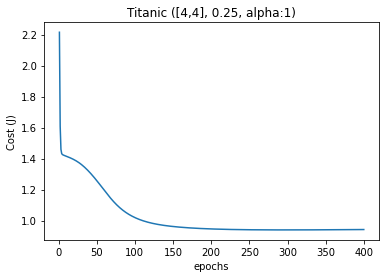

In [6]:
df = pd.read_csv('./data/titanic.csv')
df.rename(columns={"Survived": "target"}, inplace = True)
del df["Name"]

for col in df.columns:
    n = df.columns.nunique()
    if n < (len(df)/2):
        df[col] = df[col].astype('category').cat.codes

df = (df - df.min())/(df.max() - df.min())
df.fillna(0)

x = []
y = []
train_df, test_df = get_crossValidation_datasets(10, df)
for k in range(10):
    train, test = transform_datasets(train_df[k], test_df[k])
    nn1 = NeuralNetwork(4, [6,4,4,2])
    nn1.reg_lambda = 0.25
    nn1.epochs = 400
    nn1.learning_rate = 1.0

    size = len(train)
    print("Epoch size : ", size)
    
    epochs = 1
    while epochs <= 400:
        nn1.update(train)
        x.append(epochs)
        y.append(nn1.compute_cost(test))
        epochs = epochs + 1
    break

plt.plot(x,y)
plt.xlabel("epochs")
plt.ylabel("Cost (J)")
plt.title('Titanic ([4,4], 0.25, alpha:1)')
plt.show()

Epoch size :  431


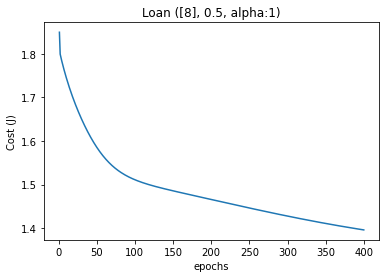

In [7]:
df = pd.read_csv('./data/loan.csv')
df.rename(columns={"Loan_Status": "target"}, inplace = True)
del df["Loan_ID"]

for col in df.columns:
    n = df.columns.nunique()
    if n < (len(df)/2):
        df[col] = df[col].astype('category').cat.codes

df = (df - df.min())/(df.max() - df.min())
df.fillna(0)
x = []
y = []
train_df, test_df = get_crossValidation_datasets(10, df)
for k in range(10):
    train, test = transform_datasets(train_df[k], test_df[k])
    nn1 = NeuralNetwork(3, [11,8,2])
    nn1.reg_lambda = 0.5
    nn1.epochs = 400
    nn1.learning_rate = 1.0

    size = len(train)
    print("Epoch size : ", size)
    
    epochs = 1
    while epochs <= 400:
        nn1.update(train)
        x.append(epochs)
        y.append(nn1.compute_cost(test))
        epochs = epochs + 1
    break

plt.plot(x,y)
plt.xlabel("epochs")
plt.ylabel("Cost (J)")
plt.title('Loan ([8], 0.5, alpha:1)')
plt.show()